# Weather Recognition 

This notebook classifies images of 6 different weather conditions (so called "snow", "fog", "rain", "lightning", "shine", and "sunrise")

<center><img src="https://media.wired.co.uk/photos/606dba1c9a15f73a597a2aa1/master/w_1600,c_limit/weather.jpg, width=100" alt="Weather Image" width=250></center>

### Import Libraries

In [ ]:
from collections import namedtuple
import copy, math, os, sys, torch
import matplotlib.pyplot as plt
import numpy as np
from operator import add
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score
from torch import Tensor, nn, optim
import torch.nn.functional as F
import torchvision.utils
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Loading Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# %cd /content/drive/My\ Drive/

**Analyzing dataset**

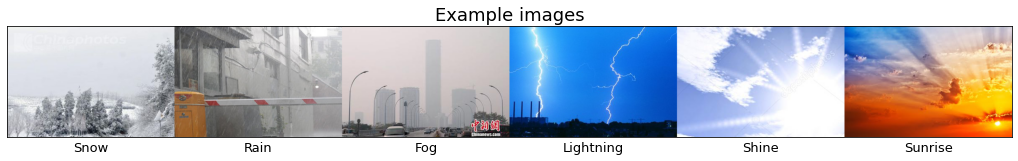

In [ ]:
classes = ('Snow', 'Rain', 'Fog', 'Lightning', 'Shine', 'Sunrise')

snow_img = Image.open('../input/weathercondimages/WeatherCondImages/snow/0841.jpg')
rain_img = Image.open('../input/weathercondimages/WeatherCondImages/rain/1215.jpg')
fog_img = Image.open('../input/weathercondimages/WeatherCondImages/fog/4157.jpg')
lightning_img = Image.open('../input/weathercondimages/WeatherCondImages/lightning/1976.jpg')
shine_img = Image.open('../input/weathercondimages/WeatherCondImages/shine/shine18.jpg')
sunrise_img = Image.open('../input/weathercondimages/WeatherCondImages/sunrise/sunrise60.jpg')
example_imgs = [snow_img,rain_img, fog_img,lightning_img , shine_img, sunrise_img]

w, h = example_imgs[2].size
grid = Image.new('RGBA', size=(6*w, h))
grid_w, grid_h = grid.size
ls = grid_w/6   # label spacing

for i, img in enumerate(example_imgs):
    grid.paste(img, box=(i%6*w, i//6*h))

plt.figure(figsize=(18,10))
plt.title('Example images', fontsize=18)
plt.imshow(grid)
plt.xticks([ls-ls/2, ls*2-ls/2, ls*3-ls/2, ls*4-ls/2, ls*5-ls/2, ls*6-ls/2], classes, fontsize=13)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.yticks([])
plt.show()

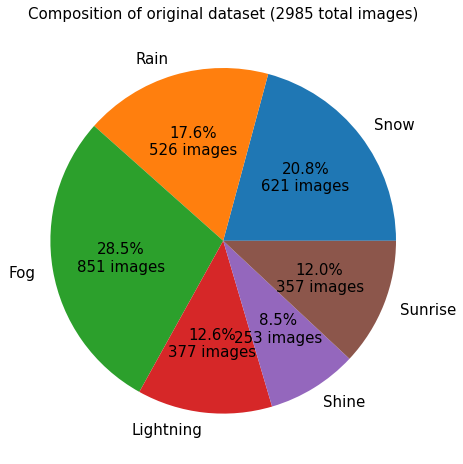

In [ ]:
num_snow = len(os.listdir('../input/weathercondimages/WeatherCondImages/snow/'))
num_rain = len(os.listdir('../input/weathercondimages/WeatherCondImages/rain/'))
num_fog = len(os.listdir('../input/weathercondimages/WeatherCondImages/fog/'))
num_lightning = len(os.listdir('../input/weathercondimages/WeatherCondImages/lightning/'))
num_shine = len(os.listdir('../input/weathercondimages/WeatherCondImages/shine/'))
num_sunrise = len(os.listdir('../input/weathercondimages/WeatherCondImages/sunrise/'))

# Plot distribution of classes
def label_pie(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n{:d} images".format(pct, absolute)

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
weather_conditions = ['Snow', 'Rain', 'Fog', 'Lightning', 'Shine', 'Sunrise']
num_images = [num_snow,num_rain,num_fog,num_lightning,num_shine,num_sunrise]
ax.pie(num_images, labels = weather_conditions, autopct=lambda pct: label_pie(pct, num_images), textprops={'fontsize': 15})
plt.title('Composition of original dataset ({} total images)'.format(sum(num_images)), fontsize=15)
plt.show()

**Apply augmentation and split into train, validation, and test**

In [ ]:
class WeatherDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

# Load data onto GPU if available
def preprocess(x, y):
    return x.to(dev), y.to(dev)

In [ ]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

original_dataset = datasets.ImageFolder('../input/weathercondimages/WeatherCondImages/', transform = transformations)
og_trn_size = int(0.7 * len(original_dataset))
og_val_size = int(0.1 * len(original_dataset))
og_tst_size = len(original_dataset) - og_trn_size - og_val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(original_dataset, [og_trn_size, og_val_size, og_tst_size])

# Use data augmentation to increase number of training samples
augment_train_ds1 = copy.deepcopy(train_ds)
augment_train_ds1.dataset.transform = transforms.Compose([transforms.Resize(255),
                                                         transforms.RandomCrop(224),
                                                         transforms.RandomHorizontalFlip(p=1),
                                                         transforms.ToTensor()])


train_ds = torch.utils.data.ConcatDataset([train_ds, augment_train_ds1])

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=len(val_ds))
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds))

train_dl = WeatherDataLoader(train_dl, preprocess)
val_dl = WeatherDataLoader(val_dl, preprocess)
test_dl = WeatherDataLoader(test_dl, preprocess)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  


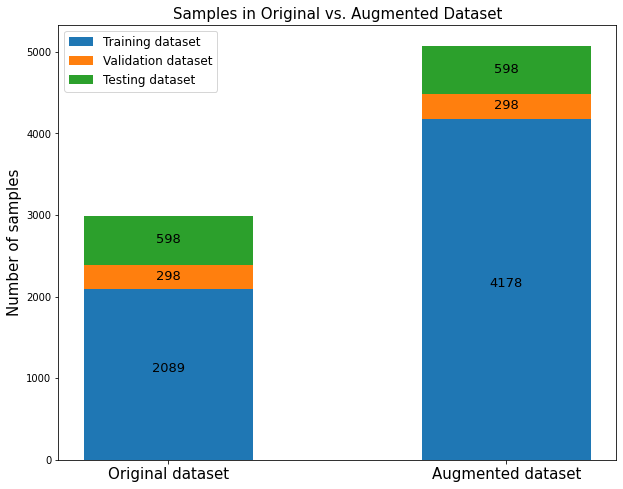

In [ ]:
labels = ['Original dataset', 'Augmented dataset']
train_nos = [og_trn_size, len(train_ds)]
val_nos = [og_val_size, len(val_ds)]
test_nos = [og_tst_size, len(test_ds)]
width = 0.5
fig, ax = plt.subplots(figsize=(10,8))
trn_bars = ax.bar(labels, train_nos, width, label='Training dataset')
val_bars = ax.bar(labels, val_nos, width, bottom=train_nos, label='Validation dataset')
tst_bars = ax.bar(labels, test_nos, width, bottom=list(map(add, train_nos, val_nos)), label='Testing dataset')
for i in range(len(trn_bars)):
    ax.annotate(str(train_nos[i]), xy=(labels[i],train_nos[i]/2), ha='center', va='bottom', fontsize='13')
    ax.annotate(str(val_nos[i]), xy=(labels[i],val_nos[i]/2+train_nos[i]-63), ha='center', va='bottom', fontsize='13')
    ax.annotate(str(test_nos[i]), xy=(labels[i],test_nos[i]/2+list(map(add, train_nos, val_nos))[i]-65), ha='center', va='bottom', fontsize='13')
ax.set_ylabel('Number of samples', fontsize='15')
ax.set_title('Samples in Original vs. Augmented Dataset', fontsize='15')
ax.set_xticklabels(labels, fontsize='15')
ax.legend(fontsize='12')
plt.show()

### Training and evaluating functions

In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy_score(labels.cpu().detach().numpy(),predicted.argmax(1).cpu().detach().numpy()), 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    acc = accuracy_score(total_labels, total_predictions)
    print(f"Epoch Accuracy:{acc}")
    # print("-------")
    return metrics, all_losses, acc


def predict(model, val_dataloder, criterion, device="cuda:0"):
    model = model.to(device).eval()
    total_loss = 0
    losses = []
    predicted_classes = np.array([])
    true_classes = np.array([])
    with tqdm(total=len(val_dataloder), file=sys.stdout) as prbar:
        for images, labels in val_dataloder:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy_score(labels.cpu().detach().numpy(),predicted.argmax(1).cpu().detach().numpy()), 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy())
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())
            losses.append(loss.detach().item())
    acc = accuracy_score(true_classes, predicted_classes)
    print(f"Epoch Accuracy:{acc}")
    print("-------")
    return losses, predicted_classes, true_classes, acc


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    all_train_losses = []
    epoch_train_losses = []
    epoch_train_acc = []
    epoch_eval_losses = []
    epoch_eval_acc = []
    for epoch in range(n_epochs):
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses, epoch_acc = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        epoch_train_acc.append(epoch_acc)
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            losses, predicted_classes, true_classes, eval_acc = predict(
                model=model,
                val_dataloder=val_dataloader,
                criterion=criterion
            )
        metric_loss = {"loss": np.sum(losses) / len(losses)}
        epoch_eval_losses.append(metric_loss["loss"])
        epoch_eval_acc.append(eval_acc)
    return epoch_train_losses, epoch_eval_losses, epoch_train_acc, epoch_eval_acc

In [ ]:
def plot_training_val(train_losses, val_losses, train_acc, val_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    fig.suptitle('Training Progress', fontsize=20)

    ax1.plot(train_losses)
    ax1.plot(val_losses)
    ax1.set_title('Loss', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_yscale('log')
    ax1.legend(['train', 'validation'], loc = 'upper right', fontsize=12)

    ax2.plot(np.multiply(train_acc,100))
    ax2.plot(np.multiply(val_acc,100))
    ax2.set_title('Accuracy', fontsize=14)
    ax2.set_ylabel('Accuracy (%)', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.legend(['train', 'validation'], loc = 'lower right', fontsize=12)
    plt.show()

In [ ]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
def testing(model, test_dl, classes):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    correct = 0
    total = 0
    confusion_matrix = np.zeros((len(classes), len(classes)))

    total_predicted = []
    total_confidence = []
    with torch.no_grad():
        for images, labels_img in test_dl:
            i = 0
            for images_ch, labels_ch in zip(chunks(images,15), chunks(labels_img,15)):
              if i == 0:
                images_new = images_ch
              else:
                images_new = torch.cat((images_new, images_ch))
              predictions = model(images_ch)
              confidence, predicted = torch.max(predictions.data, 1)
              total += labels_ch.size(0)
              correct += (predicted == labels_ch).sum().item()
              total_predicted += predicted
              total_confidence += confidence
              i += 1
              # Analyse errors for per-class accuracy and confusion matrix
              for true_label, pred_label in zip(labels_ch, predicted):
                  if true_label == pred_label:
                      correct_pred[classes[true_label]] += 1
                  total_pred[classes[true_label]] += 1
                  confusion_matrix[true_label, pred_label] += 1
    total_pr = []
    total_conf = []
    for el, el2 in zip(total_predicted, total_confidence):
      total_pr.append(int(el.cpu().detach().numpy()))
      total_conf.append(float(el2.cpu().detach().numpy())/10)

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

    print('----------------------------------------')
    print('Network Accuracy: {:.2f} %'.format(100 * correct / total))
    print('----------------------------------------')
    print(classification_report(labels_img.cpu().detach().numpy(), np.array(total_pr)))
    return total_pr, labels_img, confusion_matrix, images_new, total_conf

In [ ]:
def precision_recall_bar(total_pr, labels):
    bar_labels = ['Snow', 'Rain', 'Fog', 'Lightning', 'Shine', 'Sunrise']
    recalls = np.multiply(recall_score(labels.cpu().detach().numpy(), np.array(total_pr), average=None), 100)
    width = 0.8
    fig, ax = plt.subplots(figsize=(10,6))
    bars = ax.bar(bar_labels, recalls, width, color=['silver', 'steelblue', 'skyblue', 'darkorange', 'seagreen', 'plum'])
    for i in range(len(bars)):
        ax.annotate('{:.2f}%'.format(recalls[i]), xy=(bar_labels[i],recalls[i]/2), ha='center', va='bottom', fontsize='15')
    ax.set_ylabel('Class Recall (%)', fontsize='15')
    ax.set_title('Model Recall\nWeighted average = {:.3f}'.format(np.multiply(recall_score(labels.cpu().detach().numpy(), np.array(total_pr), average='weighted'), 100)), fontsize='15')
    ax.set_xticklabels(bar_labels, fontsize='15')
    plt.show()

    precs = np.multiply(precision_score(labels.cpu().detach().numpy(), np.array(total_pr), average=None), 100)
    width = 0.8
    fig, ax = plt.subplots(figsize=(10,6))
    bars = ax.bar(bar_labels, precs, width, color=['silver', 'steelblue', 'skyblue', 'darkorange', 'seagreen', 'plum'])
    for i in range(len(bars)):
        ax.annotate('{:.2f}%'.format(precs[i]), xy=(bar_labels[i],precs[i]/2), ha='center', va='bottom', fontsize='15')

    ax.set_ylabel('Class Precision (%)', fontsize='15')
    ax.set_title('Model Precision\nWeighted average = {:.3f}'.format(np.multiply(precision_score(labels.cpu().detach().numpy(), np.array(total_pr), average='weighted'), 100)), fontsize='15')
    ax.set_xticklabels(bar_labels, fontsize='15')

In [ ]:
def plot_confusion_matrix(classes, confusion_matrix):
    plt.figure(figsize=(8,5))
    class_names = list(classes)
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, cmap='summer', annot=True, annot_kws={"size":15}, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.title('Confusion matrix', fontsize=15)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()

In [ ]:
def plot_examples_test(images_new, total_pr, total_conf, labels):
    classes_predict = ('Fog', 'Lightning', 'Rain', 'Shine', 'Snow', 'Sunrise')
    grid_img = to_pil_image(torchvision.utils.make_grid(images_new[:15], nrow=5))
    width, height = grid_img.size
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(grid_img, 'RGBA')

    x_border = 180
    y_border = 50

    i = 0
    for row in range(1,3+1):
      for col in range(1,5+1):
      
        x = width*col/5 - width/5 * 0.96
        y = height*row/3 - 219

        draw.rectangle((x-3, y-1, x + x_border, y + y_border), fill=(0,0,0,180))

        pred_msg = 'Prediction: {}'.format(classes_predict[total_pr[i]])
        lab_msg = 'Label: {}'.format(classes_predict[labels[i]])
        draw.text((x,y), lab_msg, fill='white', font=font)
        draw.text((x,y+15), pred_msg, fill='white', font=font)

        i+=1

    plt.figure(figsize=(20,20))
    plt.imshow(grid_img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Models


* VGG16


In [ ]:
from torchvision.models import vgg

In [ ]:
vgg16_model = vgg.vgg16(pretrained=True)
vgg16_model.classifier._modules['6'] = nn.Linear(4096, 6)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.Adam(vgg16_model.parameters(), 0.0007)
criterion = nn.CrossEntropyLoss()
n_epochs = 20

In [ ]:
train_losses, val_losses, train_acc, val_acc = train(vgg16_model, train_dl, val_dl, criterion, optimizer, dev, n_epochs)

Train Epoch: 0


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.5122067975107707
Validation Epoch: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.6241610738255033
-------
Train Epoch: 1


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.6680229775011968
Validation Epoch: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.7046979865771812
-------
Train Epoch: 2


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.7584968884633796
Validation Epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.7550335570469798
-------
Train Epoch: 3


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.7807563427477262
Validation Epoch: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8456375838926175
-------
Train Epoch: 4


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8274293920536142
Validation Epoch: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.7885906040268457
-------
Train Epoch: 5


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8343705122067975
Validation Epoch: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.6241610738255033
-------
Train Epoch: 6


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.7374341790330302
Validation Epoch: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8422818791946308
-------
Train Epoch: 7


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.84585926280517
Validation Epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8758389261744967
-------
Train Epoch: 8


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.861656294877932
Validation Epoch: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8422818791946308
-------
Train Epoch: 9


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8618956438487314
Validation Epoch: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8691275167785235
-------
Train Epoch: 10


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8685974150311153
Validation Epoch: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8389261744966443
-------
Train Epoch: 11


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8465773097175682
Validation Epoch: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.7818791946308725
-------
Train Epoch: 12


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8678793681187171
Validation Epoch: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8624161073825504
-------
Train Epoch: 13


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8860698898994734
Validation Epoch: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8993288590604027
-------
Train Epoch: 14


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8997127812350407
Validation Epoch: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8221476510067114
-------
Train Epoch: 15


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8870272857826711
Validation Epoch: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8557046979865772
-------
Train Epoch: 16


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9059358544758258
Validation Epoch: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.889261744966443
-------
Train Epoch: 17


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8985160363810436
Validation Epoch: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9060402684563759
-------
Train Epoch: 18


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9076112972714218
Validation Epoch: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8926174496644296
-------
Train Epoch: 19


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9169459071325994
Validation Epoch: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8993288590604027
-------


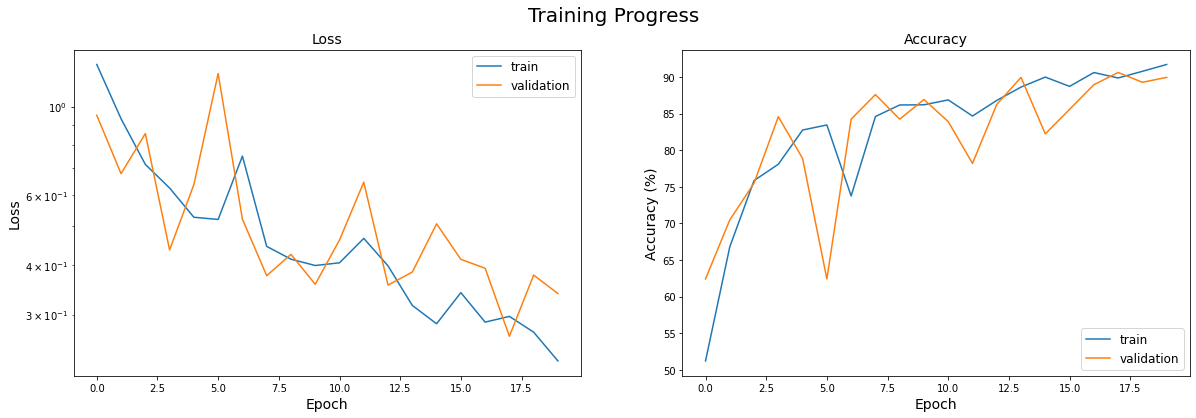

In [ ]:
plot_training_val(train_losses, val_losses, train_acc, val_acc)

In [ ]:
total_pr, labels_img, confusion_matrix, images_new, total_conf = testing(vgg16_model, test_dl, classes)

Accuracy for class Snow  is: 87.3 %
Accuracy for class Rain  is: 89.9 %
Accuracy for class Fog   is: 79.6 %
Accuracy for class Lightning is: 85.7 %
Accuracy for class Shine is: 88.9 %
Accuracy for class Sunrise is: 92.2 %
----------------------------------------
Network Accuracy: 87.12 %
----------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       158
           1       0.95      0.90      0.92        89
           2       0.81      0.80      0.80       103
           3       0.91      0.86      0.88        49
           4       0.78      0.89      0.83       135
           5       0.97      0.92      0.94        64

    accuracy                           0.87       598
   macro avg       0.89      0.87      0.88       598
weighted avg       0.88      0.87      0.87       598



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


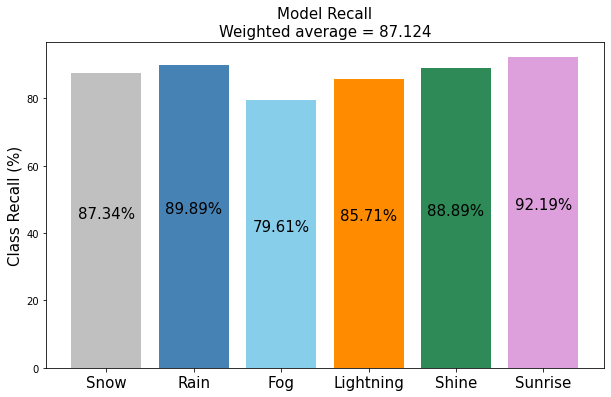

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


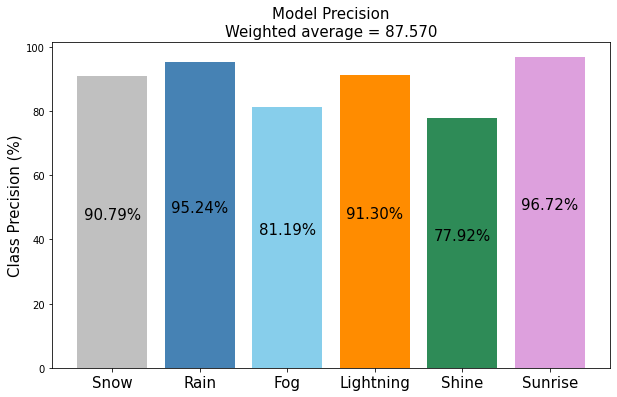

In [ ]:
precision_recall_bar(total_pr, labels_img)

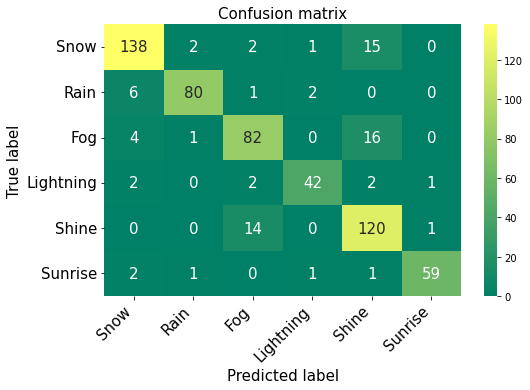

In [ ]:
plot_confusion_matrix(classes, confusion_matrix)

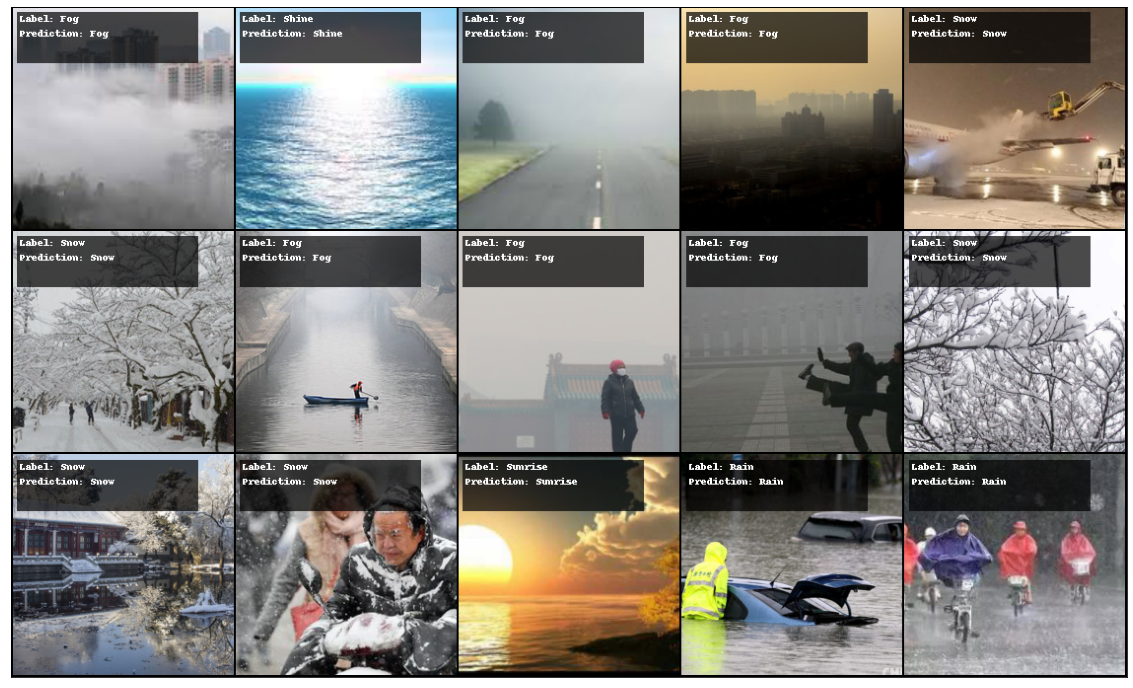

In [ ]:
plot_examples_test(images_new, total_pr, total_conf, labels_img)

- ResNet

In [ ]:
from torchvision.models import resnet50

In [ ]:
resnet50_model = resnet50(pretrained = True)
resnet50_model.fc = nn.Linear(2048, 6)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
optimizer2 = torch.optim.Adam(resnet50_model.parameters(), 0.0007)
criterion = nn.CrossEntropyLoss()
n_epochs = 20

In [ ]:
train_losses, val_losses, train_acc, val_acc = train(resnet50_model, train_dl, val_dl, criterion, optimizer2, dev, n_epochs)

Train Epoch: 0


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8389181426519866
Validation Epoch: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8590604026845637
-------
Train Epoch: 1


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8879846816658689
Validation Epoch: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9026845637583892
-------
Train Epoch: 2


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9126376256582097
Validation Epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.7550335570469798
-------
Train Epoch: 3


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9339396840593586
Validation Epoch: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8657718120805369
-------
Train Epoch: 4


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.932503590234562
Validation Epoch: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9429530201342282
-------
Train Epoch: 5


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9451890856869315
Validation Epoch: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9194630872483222
-------
Train Epoch: 6


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9468645284825276
Validation Epoch: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9395973154362416
-------
Train Epoch: 7


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9593106749640976
Validation Epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8959731543624161
-------
Train Epoch: 8


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9552417424605074
Validation Epoch: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9161073825503355
-------
Train Epoch: 9


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9564384873145045
Validation Epoch: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9093959731543624
-------
Train Epoch: 10


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9700813786500718
Validation Epoch: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9261744966442953
-------
Train Epoch: 11


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.961225466730493
Validation Epoch: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8959731543624161
-------
Train Epoch: 12


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9657730971756822
Validation Epoch: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.87248322147651
-------
Train Epoch: 13


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9648157012924844
Validation Epoch: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9463087248322147
-------
Train Epoch: 14


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9731929152704644
Validation Epoch: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9228187919463087
-------
Train Epoch: 15


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.971278123504069
Validation Epoch: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9228187919463087
-------
Train Epoch: 16


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9715174724748683
Validation Epoch: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9295302013422819
-------
Train Epoch: 17


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9719961704164672
Validation Epoch: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9362416107382551
-------
Train Epoch: 18


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9700813786500718
Validation Epoch: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9328859060402684
-------
Train Epoch: 19


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9765438008616563
Validation Epoch: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9530201342281879
-------


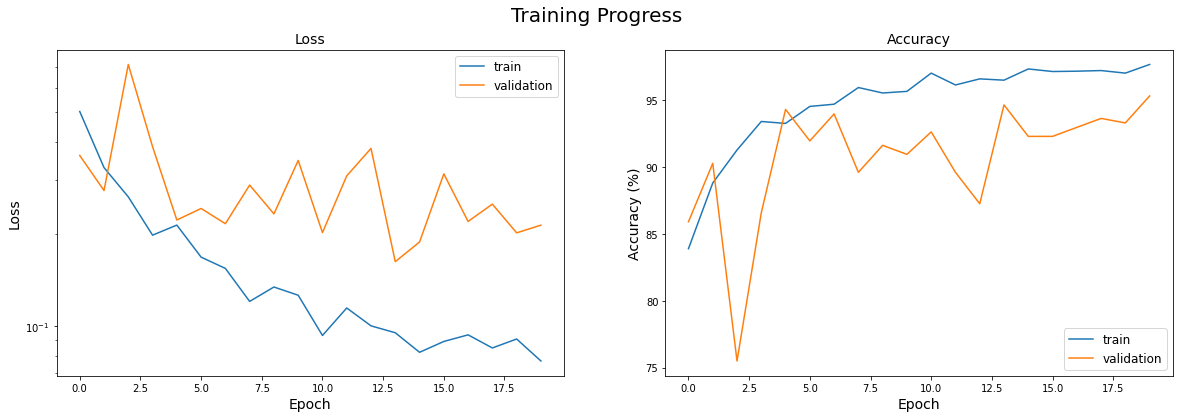

In [ ]:
plot_training_val(train_losses, val_losses, train_acc, val_acc)

In [ ]:
total_pr, labels_img, confusion_matrix, images_new, total_conf = testing(resnet50_model, test_dl, classes)

Accuracy for class Snow  is: 97.6 %
Accuracy for class Rain  is: 98.7 %
Accuracy for class Fog   is: 94.8 %
Accuracy for class Lightning is: 98.2 %
Accuracy for class Shine is: 89.3 %
Accuracy for class Sunrise is: 100.0 %
----------------------------------------
Network Accuracy: 95.82 %
----------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       169
           1       1.00      0.99      0.99        77
           2       0.89      0.95      0.92       115
           3       0.98      0.98      0.98        56
           4       0.95      0.89      0.92       121
           5       0.98      1.00      0.99        60

    accuracy                           0.96       598
   macro avg       0.96      0.96      0.96       598
weighted avg       0.96      0.96      0.96       598



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


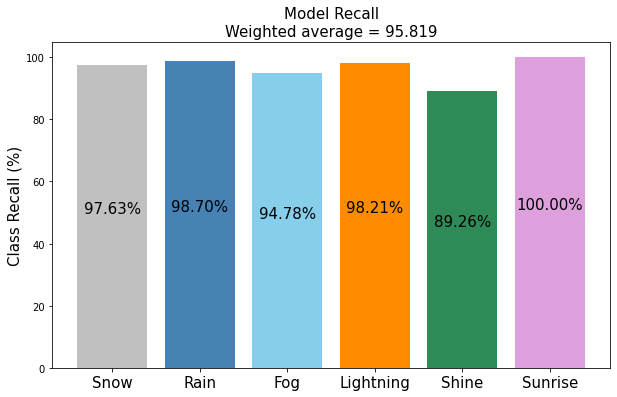

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


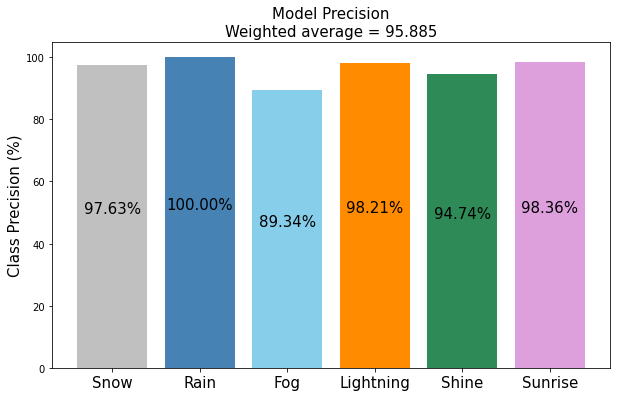

In [ ]:
precision_recall_bar(total_pr, labels_img)

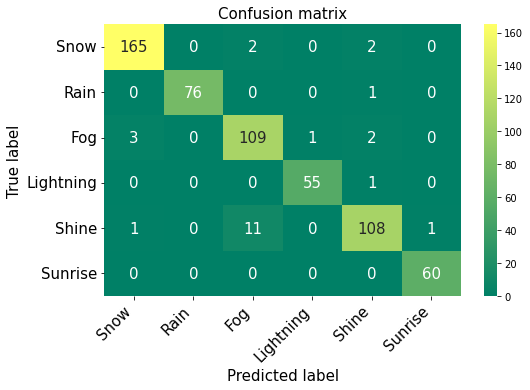

In [ ]:
plot_confusion_matrix(classes, confusion_matrix)

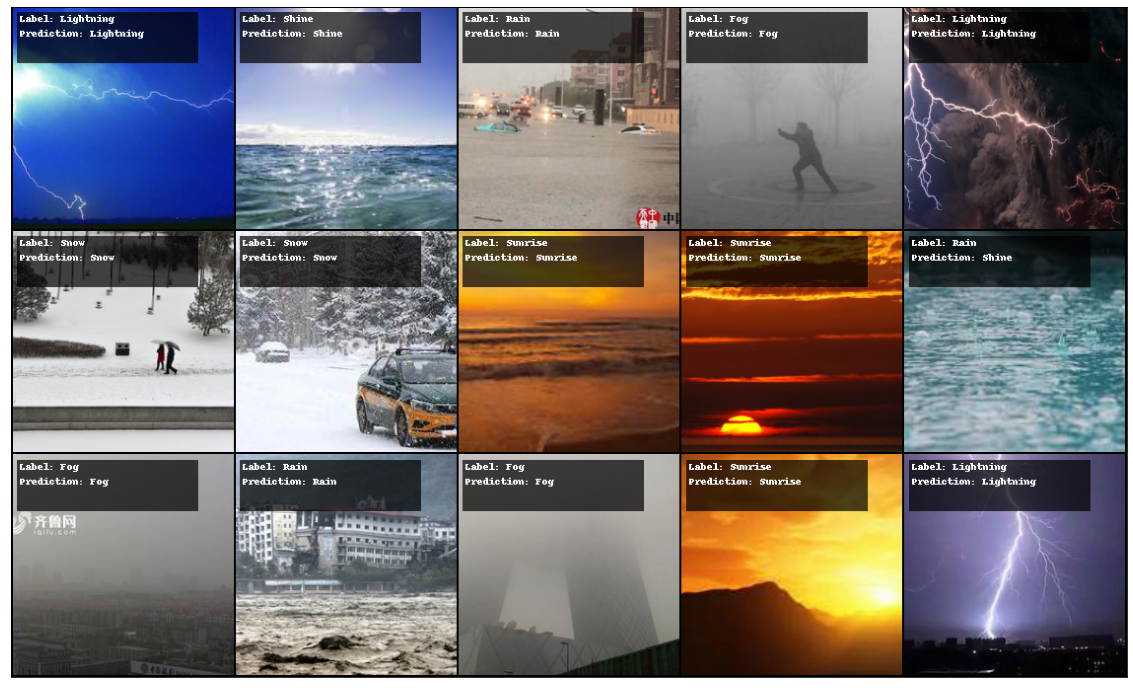

In [ ]:
plot_examples_test(images_new, total_pr, total_conf, labels_img)

- DenseNet

In [ ]:
from torchvision.models import densenet201

In [ ]:
densenet201_model = densenet201(pretrained = True)
densenet201_model.classifier = nn.Linear(1920, 6)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [ ]:
optimizer2 = torch.optim.Adam(densenet201_model.parameters(), 0.0007)
criterion = nn.CrossEntropyLoss()
n_epochs = 20

In [ ]:
train_losses, val_losses, train_acc, val_acc = train(densenet201_model, train_dl, val_dl, criterion, optimizer2, dev, n_epochs)

Train Epoch: 0


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8827190043082814
Validation Epoch: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9026845637583892
-------
Train Epoch: 1


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9155098133078028
Validation Epoch: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9161073825503355
-------
Train Epoch: 2


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9442316898037338
Validation Epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9093959731543624
-------
Train Epoch: 3


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9538056486357108
Validation Epoch: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.825503355704698
-------
Train Epoch: 4


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9514121589277166
Validation Epoch: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9026845637583892
-------
Train Epoch: 5


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9540449976065103
Validation Epoch: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9026845637583892
-------
Train Epoch: 6


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9660124461464815
Validation Epoch: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9362416107382551
-------
Train Epoch: 7


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9782192436572523
Validation Epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9026845637583892
-------
Train Epoch: 8


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9707994255624701
Validation Epoch: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9228187919463087
-------
Train Epoch: 9


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9657730971756822
Validation Epoch: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9228187919463087
-------
Train Epoch: 10


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.974150311153662
Validation Epoch: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9563758389261745
-------
Train Epoch: 11


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9810914313068454
Validation Epoch: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9630872483221476
-------
Train Epoch: 12


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9798946864528483
Validation Epoch: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9362416107382551
-------
Train Epoch: 13


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9846816658688368
Validation Epoch: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8523489932885906
-------
Train Epoch: 14


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9822881761608425
Validation Epoch: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9328859060402684
-------
Train Epoch: 15


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9815701292484442
Validation Epoch: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9362416107382551
-------
Train Epoch: 16


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9734322642412637
Validation Epoch: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.8053691275167785
-------
Train Epoch: 17


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9885112494016276
Validation Epoch: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9362416107382551
-------
Train Epoch: 18


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9909047391096218
Validation Epoch: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9093959731543624
-------
Train Epoch: 19


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9801340354236476
Validation Epoch: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9228187919463087
-------


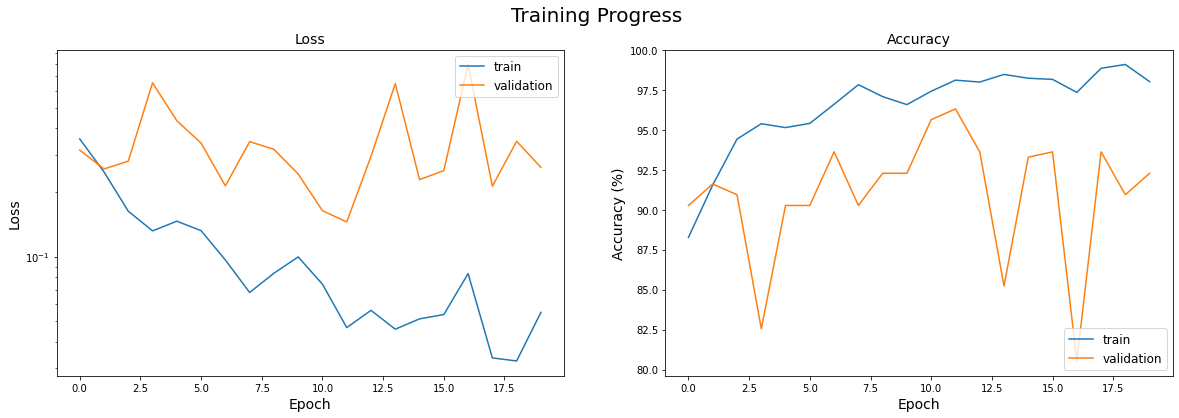

In [ ]:
plot_training_val(train_losses, val_losses, train_acc, val_acc)

In [ ]:
total_pr, labels_img, confusion_matrix, images_new, total_conf = testing(densenet201_model, test_dl, classes)

Accuracy for class Snow  is: 97.0 %
Accuracy for class Rain  is: 97.4 %
Accuracy for class Fog   is: 90.4 %
Accuracy for class Lightning is: 96.4 %
Accuracy for class Shine is: 86.0 %
Accuracy for class Sunrise is: 100.0 %
----------------------------------------
Network Accuracy: 93.81 %
----------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       169
           1       1.00      0.97      0.99        77
           2       0.89      0.90      0.90       115
           3       1.00      0.96      0.98        56
           4       0.92      0.86      0.89       121
           5       0.95      1.00      0.98        60

    accuracy                           0.94       598
   macro avg       0.95      0.95      0.95       598
weighted avg       0.94      0.94      0.94       598



- EfficientNet

In [ ]:
from torchvision.models import efficientnet_b4

In [ ]:
efficientnet_b4_model = efficientnet_b4(pretrained = True)
efficientnet_b4_model.classifier._modules['1'] = nn.Linear(1792, 6)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [ ]:
optimizer2 = torch.optim.Adam(efficientnet_b4_model.parameters(), 0.0007)
criterion2 = nn.CrossEntropyLoss()
n_epochs = 20

In [ ]:
train_losses2, val_losses2, train_acc2, val_acc2 = train(efficientnet_b4_model, train_dl, val_dl, criterion2, optimizer2, dev, n_epochs)

Train Epoch: 0


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.8626136907611297
Validation Epoch: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.959731543624161
-------
Train Epoch: 1


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9822881761608425
Validation Epoch: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9664429530201343
-------
Train Epoch: 2


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9894686452848253
Validation Epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9530201342281879
-------
Train Epoch: 3


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9897079942556247
Validation Epoch: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9429530201342282
-------
Train Epoch: 4


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.992101483963619
Validation Epoch: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9496644295302014
-------
Train Epoch: 5


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9928195308760173
Validation Epoch: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9563758389261745
-------
Train Epoch: 6


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9932982288176161
Validation Epoch: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9832214765100671
-------
Train Epoch: 7


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.996649114408808
Validation Epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9731543624161074
-------
Train Epoch: 8


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9918621349928195
Validation Epoch: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9563758389261745
-------
Train Epoch: 9


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.996649114408808
Validation Epoch: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9563758389261745
-------
Train Epoch: 10


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9947343226424127
Validation Epoch: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9563758389261745
-------
Train Epoch: 11


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9961704164672092
Validation Epoch: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9463087248322147
-------
Train Epoch: 12


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9947343226424127
Validation Epoch: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9697986577181208
-------
Train Epoch: 13


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9978458592628052
Validation Epoch: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9530201342281879
-------
Train Epoch: 14


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.994973671613212
Validation Epoch: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9463087248322147
-------
Train Epoch: 15


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9935375777884156
Validation Epoch: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9563758389261745
-------
Train Epoch: 16


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9959310674964098
Validation Epoch: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9563758389261745
-------
Train Epoch: 17


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9976065102920058
Validation Epoch: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.959731543624161
-------
Train Epoch: 18


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9971278123504069
Validation Epoch: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9563758389261745
-------
Train Epoch: 19


  0%|          | 0/131 [00:00<?, ?it/s]

Epoch Accuracy:0.9971278123504069
Validation Epoch: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch Accuracy:0.9630872483221476
-------


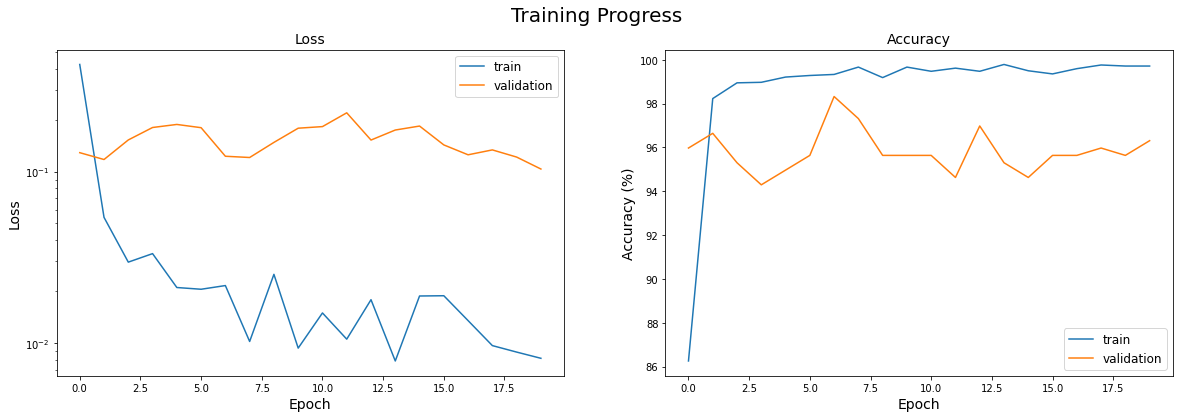

In [ ]:
plot_training_val(train_losses2, val_losses2, train_acc2, val_acc2)

In [ ]:
total_pr2, labels_img2, confusion_matrix2, images_new2, total_conf2 = testing(efficientnet_b4_model, test_dl, classes)

Accuracy for class Snow  is: 100.0 %
Accuracy for class Rain  is: 100.0 %
Accuracy for class Fog   is: 91.3 %
Accuracy for class Lightning is: 98.2 %
Accuracy for class Shine is: 97.5 %
Accuracy for class Sunrise is: 100.0 %
----------------------------------------
Network Accuracy: 97.66 %
----------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       169
           1       1.00      1.00      1.00        77
           2       0.99      0.91      0.95       115
           3       0.98      0.98      0.98        56
           4       0.96      0.98      0.97       121
           5       0.97      1.00      0.98        60

    accuracy                           0.98       598
   macro avg       0.98      0.98      0.98       598
weighted avg       0.98      0.98      0.98       598



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


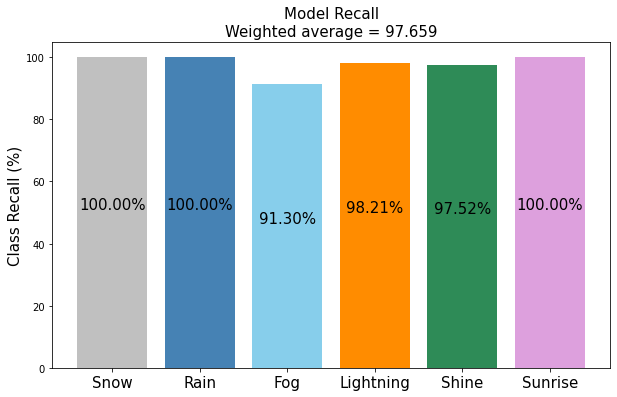

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


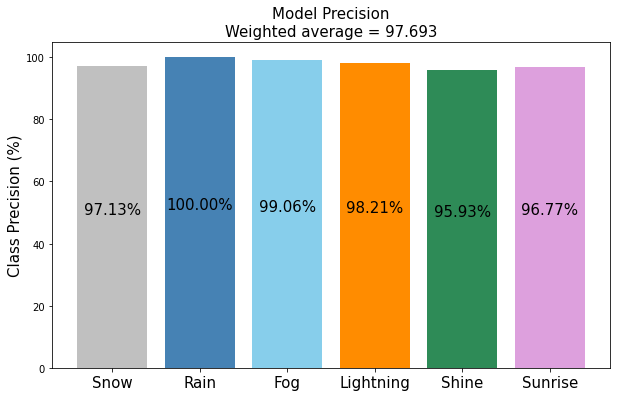

In [ ]:
precision_recall_bar(total_pr2, labels_img2)

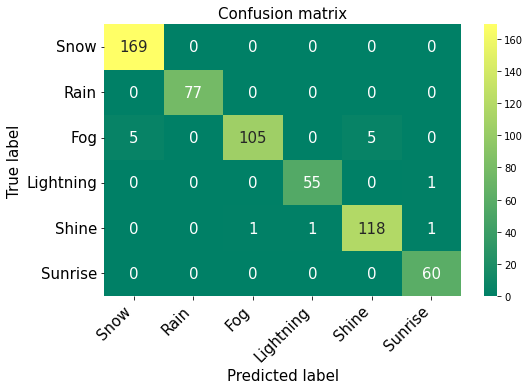

In [ ]:
plot_confusion_matrix(classes, confusion_matrix2)

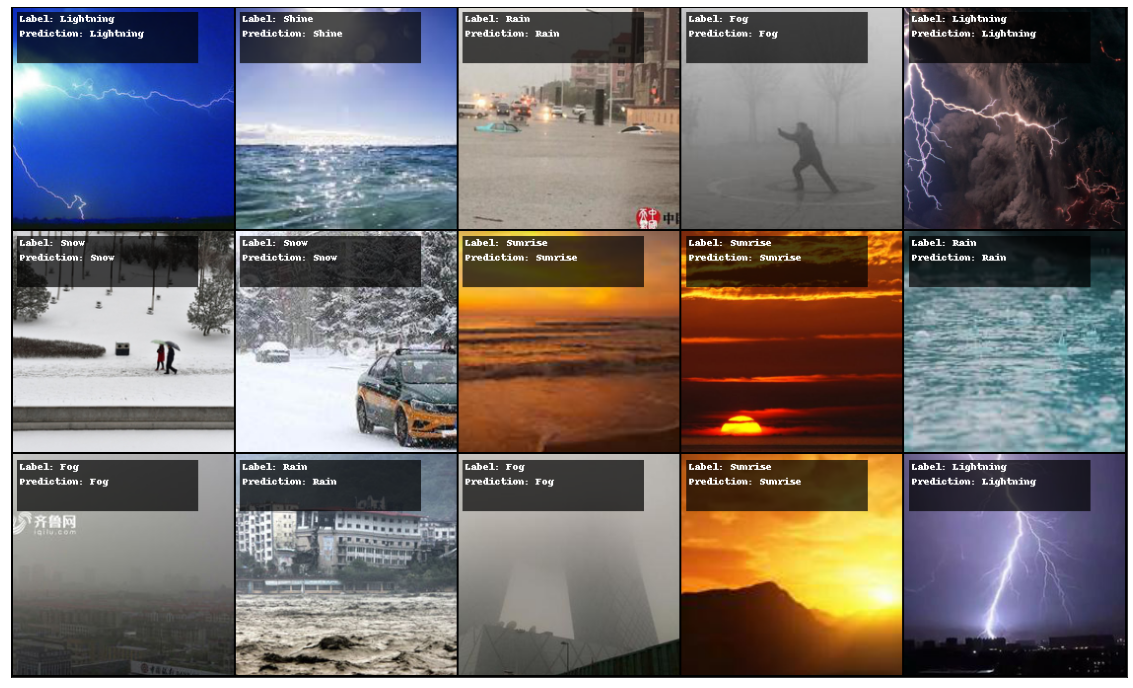

In [ ]:
plot_examples_test(images_new2, total_pr2, total_conf2, labels_img2)